In [4]:
#Load up our data
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

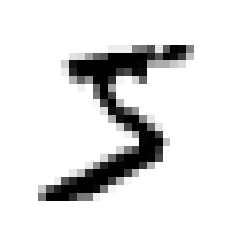

In [5]:
#Plot a digit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

X = mnist['data']
y = mnist['target']
y = y.astype(np.uint8)
some_digit = X[0:1]
some_digit_image = some_digit.values.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

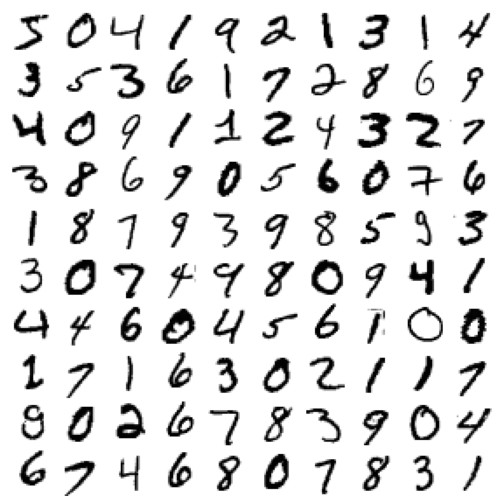

In [6]:
#Plot a sample of the data set
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instances[i:i+1].values.reshape(size,size) for i in range(instances.shape[0])]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
#%%
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.savefig("ref/more_digits_plot")
plt.show()

In [7]:
#Test and train sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
#Binary classification (one digit) using Stochastic Gradient Descent (SGD)
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

#SGD
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

print("Is this digit a 5?")
print(sgd_clf.predict(some_digit))


Is this digit a 5?
[ True]


In [9]:
#Custom Cross-Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
skf_split = skfolds.split(X_train, y_train_5)

In [10]:
for train_index, test_index in skf_split:
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.values[train_index]
    y_train_folds = y_train_5.values[train_index]
    X_test_fold = X_train.values[test_index]
    y_test_fold = y_train_5.values[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [11]:
#Provided Cross-Validation
from sklearn.model_selection import cross_val_score

print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy"))


[0.95035 0.96035 0.9604 ]


In [12]:
#Feels good, but we're only doing fives so how does something dumber do?
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
print(cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy"))


[0.91125 0.90855 0.90915]


In [13]:
#Taking a look at our confusion matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

#Columns represent predicted classes and rows represent actual classes
#           non-5   yes-5 (predicted)
#  non-5 [   ###     ###    ]
#  yes-5 [   ###     ###    ]
# (actual)
print("What's our confusion matrix?")
print(confusion_matrix(y_train_5, y_train_pred))

#And of course out precision and recall scores
#Precision = (True Positives)/(True Positives + False Positives)
#Recall = (True Positives)/(True Positives + False Negatives)
from sklearn.metrics import precision_score, recall_score
print("How's our...")
print("Precision: "+str(precision_score(y_train_5, y_train_pred))) # == 4096 / (4096 + 1522)
print("Recall: "+str(recall_score(y_train_5, y_train_pred))) # == 4096 / (4096 + 1325)

#Harmonic Mean? Tells us how close our precision and recall scores are
#   High score may not always be a good thing
#   Demonstrates precision/recall tradeoff
from sklearn.metrics import f1_score

print("Harmonic Mean (F1): "+str(f1_score(y_train_5, y_train_pred)))


What's our confusion matrix?
[[53892   687]
 [ 1891  3530]]
How's our...
Precision: 0.8370879772350012
Recall: 0.6511713705958311
Harmonic Mean (F1): 0.7325171197343846


In [14]:
#No control over decision thresholds for some classifications, but wanna see 'em anyways?
y_scores = sgd_clf.decision_function(some_digit)
print(y_scores)
threshold = 0 #Default for SGD
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]
[False]


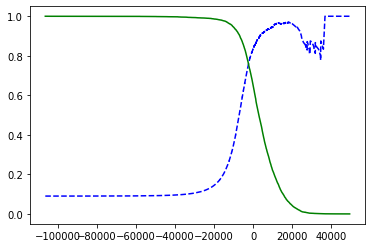

In [15]:
#So which classifier do we use?
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


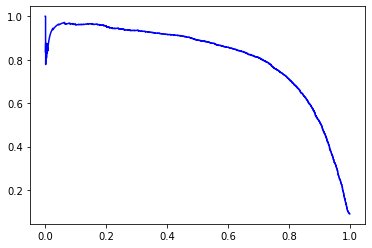

In [16]:
#How does precision vs recall look?
plt.plot(recalls, precisions, "b")
plt.show()

#By observing this plot, we can choose a threshold corresponding to whatever precision we want

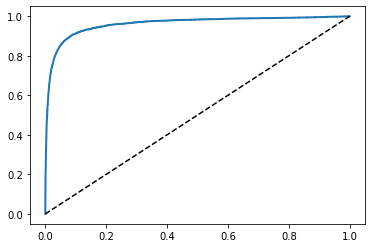

ROC AUC: 0.9604938554008616


In [17]:
#ROC Curves
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal

plot_roc_curve(fpr, tpr)
plt.show()

from sklearn.metrics import roc_auc_score

print("ROC AUC: "+str(roc_auc_score(y_train_5, y_scores)))


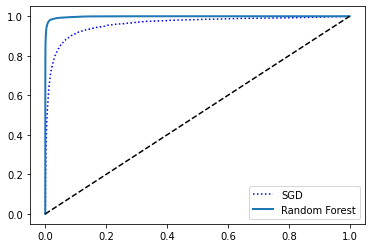

Random Forest ROC AUC: 0.9983436731328145


In [18]:
#Trying Random Forest for MNIST and investigating its ROC
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

#Area under curve is greater so Random Forest is better
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

print("Random Forest ROC AUC: "+str(roc_auc_score(y_train_5, y_scores_forest)))

In [19]:
#Doing some Multiclass Classification (How about determing 1 from all digits??) (use SVM for this try)
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict(some_digit)

print("What does this classifier think for this digit?")
some_digit_scores = svm_clf.decision_function(some_digit)
print(some_digit_scores)
print(np.argmax(some_digit_scores))

What does this classifier think for this digit?
[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
5


In [20]:
#Choose between OvO or OvR
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
print("OvR Prediction: "+str(ovr_clf.predict(some_digit)))
len(ovr_clf.estimators_)

sgd_clf.fit(X_train, y_train)
print("SGD Prediction: "+str(sgd_clf.predict(some_digit)))
print("SGD Scores: "+str( sgd_clf.decision_function(some_digit)))


OvR Prediction: [5]
SGD Prediction: [3]
SGD Scores: [[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]


In [21]:
#Accuracy measures and making it better
print("Cross-Validation Score: "+str(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")))

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print("Scaled Cross-Val Score: "+str(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3,        scoring="accuracy")))

Cross-Validation Score: [0.87365 0.85835 0.8689 ]
Scaled Cross-Val Score: [0.8983 0.891  0.9018]


Confusion
[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


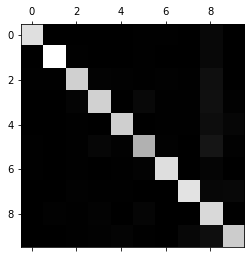

In [22]:
#Some error analysis for these multiclassers
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print("Confusion\n"+str(conf_mx))

#Plot the absolute number of errors
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

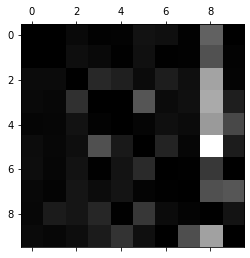

In [23]:
#Plot the error rates
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

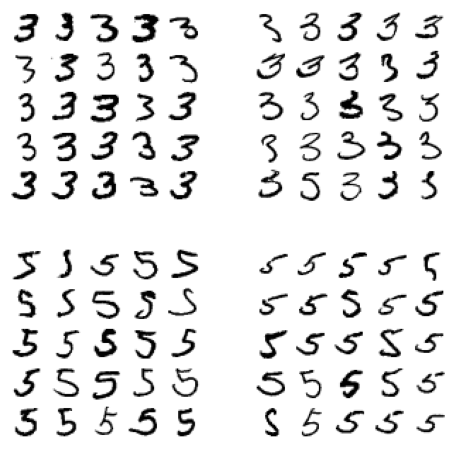

In [24]:
#Take a look at errors in the pictures
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [25]:
#Multilabel Classification (many labels per prediction)
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) #Is the number large?
y_train_odd = (y_train % 2 == 1) #Is the number odd?
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict(some_digit)

#Eval
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")
print("F1 Score: "+str(f1_score))


F1 Score: <function f1_score at 0x000002AD539C1160>


In [29]:
#Multioutput classification (clean things up and then classify)
#De-noise
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

#Classify
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict(X_test_mod[4:5])
print(clean_digit)
# plot_digits(clean_digit)

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.  79.  43.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.   0.   0.   0.
    0.   0.   0.   0.   0.  31. 246.  12.   0.   0.   0.   0.   